In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
import scipy.io as sio
from scipy.stats import pearsonr
from scipy import ndimage as nd
from scipy import misc
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import PIL.Image as pim
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import theano
import theano.tensor as T

import src.pyNumpyUtility as pnu
import src.pyFWRF as prf    
from src.pyFWRF import FWRF_model, fpX

Couldn't import dot_parser, loading of dot files will not be possible.
theano floatX: float32
numpy floatX: <type 'numpy.float32'>


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
# folder in which resides the vim-1, dataset, the precalculated feature space and the image dataset.
dataset_dir = "/home/styvesg/Documents/PostDoc/Datasets/vim-1/"

In [3]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

root_dir   = os.getcwd() + '/'
output_dir = root_dir+"output/"

print "Time Stamp: %s" % timestamp

Time Stamp: Mar-22-2017_0239


In [4]:
def save_stuff(save_to_this_file, data_objects_dict):
    failed = []
    with h5py.File(save_to_this_file+'.h5py', 'w') as hf:
        for k,v in data_objects_dict.iteritems():
            try:
                hf.create_dataset(k,data=v)
                print 'saved %s in h5py file' %(k)
            except:
                failed.append(k)
                print 'failed to save %s as h5py. will try pickle' %(k)   
    for k in failed:
        with open(save_to_this_file+'_'+'%s.pkl' %(k), 'w') as pkl:
            try:
                pickle.dump(data_objects_dict[k],pkl)
                print 'saved %s as pkl' %(k)
            except:
                print 'failed to save %s in any format. lost.' %(k)
                
def display_candidate_loss(scores, nx, ny, ns):
    dis_y = ns // 3 if ns%3==0 else ns//3+1
    s = scores.reshape((nx, ny, ns)).transpose((1,0,2))[::-1,:,:] ## The transpose and flip is just so that the candidate 
    #coordinate maatch the normal cartesian coordinate of the rf position when viewed through imshow.
    idxs = np.unravel_index(np.argmin(s), (nx,ny,ns))
    best = plt.Circle((idxs[1], idxs[0]), 0.5, color='r', fill=False, lw=2)
    
    fig = plt.figure(figsize=(15, 5*dis_y))
    smin = np.min(s)
    smax = np.max(s)
    print "score range = (%f, %f)" % (smin, smax)
    for i in range(ns):
        plt.subplot(dis_y, 3, i+1)
        plt.imshow(s[:,:,i], interpolation='None')
        plt.title('sigma canditate = %d' % i)
        plt.clim(smin, smax)
        if(idxs[2]==i):
            ax = plt.gca()
            ax.add_artist(best)
    return fig

# 1a) Load the low-rez images presented.

In [5]:
inputdata_lowrez = sio.loadmat(dataset_dir + "Stimuli.mat")
print inputdata_lowrez.keys()

['seqTrn', '__header__', '__globals__', 'stimVal', 'seqVal', 'stimTrn', '__version__']


In [6]:
npx = 96
npc = 3

trn_size = len(inputdata_lowrez["stimTrn"])
val_size = len(inputdata_lowrez["stimVal"])
data_size = trn_size + val_size

print "trn: %d, val: %d" % (trn_size, val_size)
inputData = np.ndarray(shape=(data_size, npx, npx, npc), dtype=fpX)

for i,rawim in enumerate(inputdata_lowrez["stimTrn"]):
    rawmin, rawmax = np.min(rawim), np.max(rawim)
    sim = (rawim - rawmin) * 255 / (rawmax - rawmin)               
    im = pim.fromarray(sim, mode='F').resize((npx, npx), resample=pim.BILINEAR).convert('RGB')
    inputData[i,...] = np.asarray(im)

for i,rawim in enumerate(inputdata_lowrez["stimVal"]):
    rawmin, rawmax = np.min(rawim), np.max(rawim)
    sim = (rawim - rawmin) * 255 / (rawmax - rawmin)         
    im = pim.fromarray(sim, mode='F').resize((npx, npx), resample=pim.BILINEAR).convert('RGB')
    inputData[trn_size+i,...] = np.asarray(im)
        
inputData = np.transpose((inputData - 128) / 128, (0,3,1,2))
print "Data shape = %s" % (inputData.shape,)

trnInputData = inputData[:trn_size]
valInputData = inputData[trn_size:]

trn: 1750, val: 120
Data shape = (1870, 3, 96, 96)


# 1b) Load the voxel data for all images presented.

In [7]:
voxelset = h5py.File(dataset_dir + "EstimatedResponses.mat")
print voxelset.keys()

[u'dataTrnS1', u'dataTrnS2', u'dataValS1', u'dataValS2', u'roiS1', u'roiS2', u'voxIdxS1', u'voxIdxS2']


In [8]:
subject = 'S2'
roi_names = ['other', 'V1', 'V2', 'V3', 'V3a', 'V3b', 'V4', 'LO']

In [29]:
voxeldata = np.concatenate([voxelset['dataTrn%s'%subject], voxelset['dataVal%s'%subject]], axis=0).astype(dtype=fpX)
voxelroi = voxelset['roi%s'%subject]
voxelidx = voxelset['voxIdx%s'%subject]
print voxeldata.shape

# purge all voxel that have no variance in the validation set

voxelNanMask = ~np.isnan(voxeldata).any(axis=0)
nv = np.sum(voxelNanMask)
print "%d voxels contain valid values for all images" % nv

(1870, 26329)
21256 voxels contain valid values for all images


In [30]:
voxelData = voxeldata[:, voxelNanMask].astype(dtype=fpX)
voxelROI  = voxelroi[:, voxelNanMask]
voxelIDX  = voxelidx[:, voxelNanMask]
print voxelData.shape

trnVoxelData = voxelData[:trn_size]
valVoxelData = voxelData[trn_size:]

(1870, 21256)


## (Optional) Restricted dataset

In [11]:
nv = 300
start_v = (3566 // nv) * nv
trnVoxelData = trnVoxelData[:, start_v:start_v+nv]
valVoxelData = valVoxelData[:, start_v:start_v+nv]

# 1c) Load precomputed model feature space for all images presented.

In [12]:
trn_feature_dict = h5py.File(dataset_dir + "caffe_refnet_trn_response.h5py", 'r')   # 'r' means that hdf5 file is open in read-only mode
val_feature_dict = h5py.File(dataset_dir + "caffe_refnet_val_response.h5py", 'r')

layerlist = trn_feature_dict.keys()
print layerlist

[u'conv1', u'conv2', u'conv3', u'conv4', u'conv5', u'fc6', u'fc7', u'fc8', u'prob']


In [13]:
# concatenate and sort as list
fmap_max = 1024
order = layerlist[0:8] #+layerlist[7:8]
fmaps = []
fmaps_sizes = []
fmaps_count = 0
for l in order:
    fmap = np.concatenate((np.array(trn_feature_dict[l], dtype=fpX), np.array(val_feature_dict[l], dtype=fpX)), axis=0)        
    if fmap.ndim==2:
        fmap = fmap.reshape(fmap.shape+(1,1))
    if fmap.shape[1]>fmap_max:
        #select the feature map with the most variance to the dataset
        fmap_var = np.var(fmap, axis=(0,2,3))
        most_var = fmap_var.argsort()[-fmap_max:]
        fmap = fmap[:,most_var,:,:]
    print "layer: %s, shape=%s" % (l, (fmap.shape))
    fmaps += [fmap,]
    fmaps_sizes  += [fmap.shape,]
    fmaps_count += fmap.shape[1]
    
trn_feature_dict.close()
val_feature_dict.close()

layer: conv1, shape=(1870, 96, 55, 55)
layer: conv2, shape=(1870, 256, 27, 27)
layer: conv3, shape=(1870, 384, 13, 13)
layer: conv4, shape=(1870, 384, 13, 13)
layer: conv5, shape=(1870, 256, 13, 13)
layer: fc6, shape=(1870, 1024, 1, 1)
layer: fc7, shape=(1870, 1024, 1, 1)
layer: fc8, shape=(1870, 1000, 1, 1)


## Display an example of image and feature space.

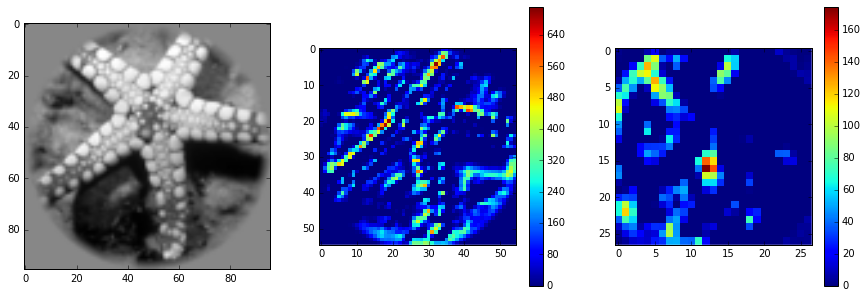

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(trnInputData[5,0,:,:], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(fmaps[0][5,2,:,:], interpolation='None')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(fmaps[1][5,10,:,:], interpolation='None')
plt.colorbar()

In [15]:
# aliases
nf = fmaps_count
fmaps_res_count = len(fmaps)
allFmaps = fmaps

# make sure we are using float32
print allFmaps[0].dtype

float32


# 2) MODELS

## Define the inputs
We can either connect the feature maps of the network directly or some precomputed values provided in a suitable list

In [16]:
#feature maps symbolic variables:
_fmaps = []
for r in range(fmaps_res_count):
    _fmaps += [T.tensor4(),] # note this has to be done explicitely, we can't just replicate the tensor object
_invar = _fmaps
# vs. connecting another theano network directly:
#_fmaps = [L.get_output(fm, deterministic=True) for fm in _aux]
#_invar = [X,]

## Define the search parameters

In [31]:
lx = ly = 20.
nx = ny = 12
smin, smax = 0.7, 8.
ns = 6

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
sharedModel_specs = [[(0., lx), (0., ly), (smin, smax)], [prf.linspace(nx), prf.linspace(ny), prf.logspace(ns)]]
# initial values of the fwrf model parameters
voxelParams = [np.full(shape=(nv, nf), fill_value=0.0, dtype=fpX), np.full(shape=(nv), fill_value=0.0, dtype=fpX)]

print "G = %d\n" % (nx*ny*ns)
#print range:
print "range x"
print sharedModel_specs[1][0](*sharedModel_specs[0][0])
print "range y"
print sharedModel_specs[1][1](*sharedModel_specs[0][1])
print "range s"
print sharedModel_specs[1][2](*sharedModel_specs[0][2])

G = 864

range x
[-9.16666698 -7.5        -5.83333349 -4.16666651 -2.5        -0.83333331
  0.83333331  2.5         4.16666651  5.83333349  7.5         9.16666698]
range y
[-9.16666698 -7.5        -5.83333349 -4.16666651 -2.5        -0.83333331
  0.83333331  2.5         4.16666651  5.83333349  7.5         9.16666698]
range s
[ 0.69999999  1.13945305  1.85479033  3.01920915  4.91463852  8.        ]


## Select the indice of one of the receptive field size to visualize the rf weight masks at every resolution required by the feature space.

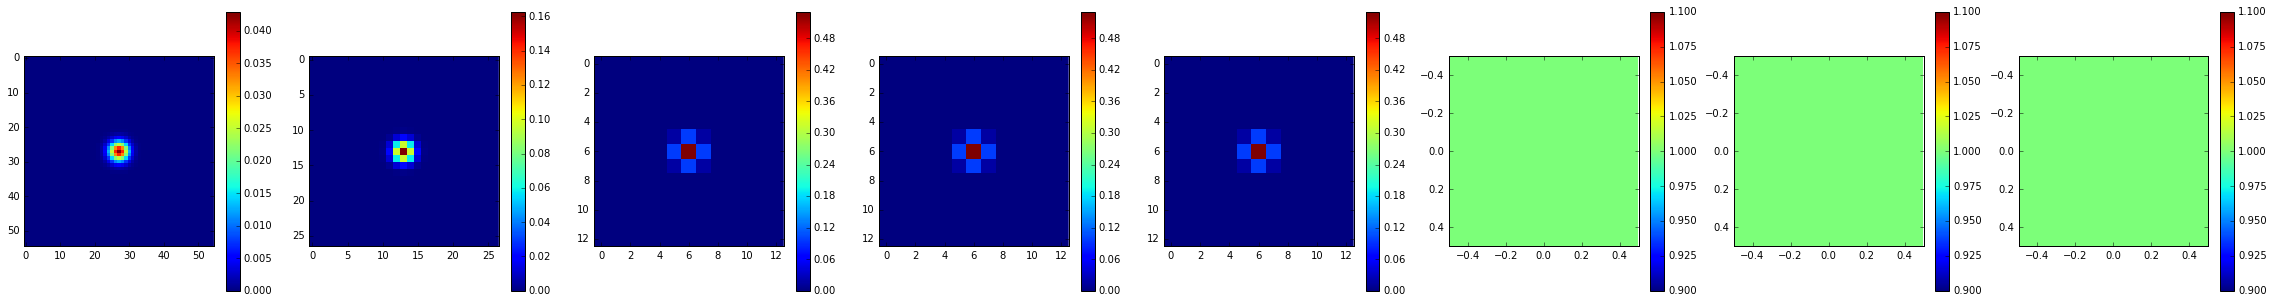

In [19]:
ith_rf_size = 0

n = len(fmaps_sizes)
plt.figure(figsize=(5*n,5))
sigmas = sharedModel_specs[1][2](*sharedModel_specs[0][2])
for i,r in enumerate(fmaps_sizes):
    _,_,z = pnu.make_gaussian_mass(0., 0., sigmas[ith_rf_size], r[2], size=20.)
    plt.subplot(1,n,i+1)
    plt.imshow(z, interpolation='None')
    plt.colorbar()

## Define the model
### The model allocates the necessary buffers and pre-compile the theano expressions.
### The model can then be used in 2 fashion:
1) By precomputing explicitely the modelspace tensor (MST) for all samples and then using the training and validation part of the MST as input to the training and validating function with the argument use_data_as_rfw_data=True.

2) By feeding the feature maps directly to the training and validation routines. The modelspace tensor will be computed under the hood. Since this may take an inordinate amount of time with hi-resolution feature maps, it is recommended to use (1).  

In [18]:
fwrf = FWRF_model(_fmaps, fmaps_sizes, _invar, fmaps_sizes,
    batches_p=(200, ny*nx), batches_o=(200, 300, ny*nx), batches_t=(200, 10*ny*nx),\
    view_angle=lx, verbose=True)

CREATING SYMBOLS

> rfw 0 with shape (1, 144, 55, 55)
> rfw 1 with shape (1, 144, 27, 27)
> rfw 2 with shape (1, 144, 13, 13)
> rfw 3 with shape (1, 144, 13, 13)
> rfw 4 with shape (1, 144, 13, 13)
> rfw 5 with shape (1, 144, 1, 1)
> rfw 6 with shape (1, 144, 1, 1)
> rfw 7 with shape (1, 144, 1, 1)
  total number of feature maps = 4424, in 8 layers
  shared rfw using approx 2.3 Mb of memory (VRAM and RAM)


Layer	: <lasagne.layers.input.InputLayer object at 0x7f7d580167d0>
Name	: None
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 4424, 144)


Layer	: <src.pyFWRF.svFWRFLayer object at 0x7f7d58016890>
Name	: None
Type	: <class 'src.pyFWRF.svFWRFLayer'>
Shape	: (None, 300, 144)
Params
        |-- W         : (4424, 300, 144)
        |-- b         : (1, 300, 144)



COMPILING...
6.23 seconds to compile theano functions


## Precompute and save the modelspace tensor

In [19]:
#log_act_func = lambda x: np.log(1+np.sqrt(np.abs(x)))
all_rfw_data = fwrf.precompute_rfw_data(allFmaps, sharedModel_specs, verbose=True, dry_run=False, nonlinearity=None, zscore=True, trn_size=trn_size, epsilon=1e-3)
print all_rfw_data.shape


>> Storing the full precomputed candidate feature time series will require approx 26.628Gb of RAM!
>> Will be divided in chunks of 4.438Gb of VRAM!

Precomputing rfw candidate responses...


100%|██████████| 6/6 [00:20<00:00,  3.48s/it]

864 rfw candidate responses took 20.811s @ 41.516 models/s
Z-scoring modelspace tensor...



6it [02:07, 21.33s/it]

(1870, 4424, 1, 864)


In [20]:
print np.amin(all_rfw_data), np.amax(all_rfw_data)

-22.7922 1328.86


In [21]:
# split the model space tensor into trn and val set.
trn_rfw_data = all_rfw_data[:trn_size]
val_rfw_data = all_rfw_data[trn_size:]

## Run the models

In [32]:
lr = 1e-4
num_epochs = 20

val_scores, best_scores, best_abs_models, best_rel_models, best_params = fwrf.shared_model_training(\
    trn_rfw_data, trnVoxelData, sharedModel_specs, voxelParams,\
    val_test_size=350, lr=lr, l2=0., num_epochs=num_epochs, output_val_scores=True, verbose=True, dry_run=False, use_data_as_rfw_data=True)


Voxel-Candidates model optimization...
70 voxel batches of size 300 with residual 256
6 candidate batches of size 144 with residual 0
for 18365184 voxelmodel fits.


0it [00:00, ?it/s]


  Voxel 0:300 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005689
    validation <loss>: 0.005693
    validation <loss>: 0.005698
    validation <loss>: 0.005703
    validation <loss>: 0.005708
    validation <loss>: 0.005713
    validation <loss>: 0.005719
    validation <loss>: 0.005723
    validation <loss>: 0.005728
    validation <loss>: 0.005733
    validation <loss>: 0.005738
    validation <loss>: 0.005742
    validation <loss>: 0.005747
    validation <loss>: 0.005752
    validation <loss>: 0.005756
    validation <loss>: 0.005760
    validation <loss>: 0.005765
    validation <loss>: 0.005769
    validation <loss>: 0.005773
    validation <loss>: 0.005777
    20 Epoch for 43200 voxelmodels took 53.181s @ 812.318 voxelmodels/s

  Voxel 0:300 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005689
    validation <loss>: 0.005693
    validation <loss>: 0.005697
    validation <loss>: 0.005702
    validation <loss>: 0.005708
    validation <loss>: 0.00571

1it [05:30, 330.79s/it]


  Voxel 300:600 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005689
    validation <loss>: 0.005693
    validation <loss>: 0.005697
    validation <loss>: 0.005702
    validation <loss>: 0.005707
    validation <loss>: 0.005711
    validation <loss>: 0.005716
    validation <loss>: 0.005720
    validation <loss>: 0.005725
    validation <loss>: 0.005729
    validation <loss>: 0.005733
    validation <loss>: 0.005737
    validation <loss>: 0.005741
    validation <loss>: 0.005745
    validation <loss>: 0.005749
    validation <loss>: 0.005753
    validation <loss>: 0.005757
    validation <loss>: 0.005761
    validation <loss>: 0.005765
    validation <loss>: 0.005769
    20 Epoch for 43200 voxelmodels took 53.257s @ 811.165 voxelmodels/s

  Voxel 300:600 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005689
    validation <loss>: 0.005693
    validation <loss>: 0.005697
    validation <loss>: 0.005702
    validation <loss>: 0.005707
    validation <loss>: 0.0

2it [11:01, 330.85s/it]


  Voxel 600:900 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005670
    validation <loss>: 0.005671
    validation <loss>: 0.005675
    validation <loss>: 0.005679
    validation <loss>: 0.005683
    validation <loss>: 0.005688
    validation <loss>: 0.005692
    validation <loss>: 0.005696
    validation <loss>: 0.005700
    validation <loss>: 0.005705
    validation <loss>: 0.005709
    validation <loss>: 0.005713
    validation <loss>: 0.005717
    validation <loss>: 0.005721
    validation <loss>: 0.005725
    validation <loss>: 0.005728
    validation <loss>: 0.005732
    validation <loss>: 0.005736
    validation <loss>: 0.005740
    validation <loss>: 0.005744
    20 Epoch for 43200 voxelmodels took 53.118s @ 813.286 voxelmodels/s

  Voxel 600:900 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005670
    validation <loss>: 0.005671
    validation <loss>: 0.005675
    validation <loss>: 0.005679
    validation <loss>: 0.005683
    validation <loss>: 0.0

3it [16:33, 331.15s/it]


  Voxel 900:1200 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005686
    validation <loss>: 0.005690
    validation <loss>: 0.005695
    validation <loss>: 0.005700
    validation <loss>: 0.005705
    validation <loss>: 0.005709
    validation <loss>: 0.005714
    validation <loss>: 0.005718
    validation <loss>: 0.005723
    validation <loss>: 0.005727
    validation <loss>: 0.005731
    validation <loss>: 0.005735
    validation <loss>: 0.005739
    validation <loss>: 0.005744
    validation <loss>: 0.005748
    validation <loss>: 0.005752
    validation <loss>: 0.005755
    validation <loss>: 0.005759
    validation <loss>: 0.005763
    validation <loss>: 0.005767
    20 Epoch for 43200 voxelmodels took 53.264s @ 811.057 voxelmodels/s

  Voxel 900:1200 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005686
    validation <loss>: 0.005690
    validation <loss>: 0.005695
    validation <loss>: 0.005699
    validation <loss>: 0.005704
    validation <loss>: 0

4it [22:04, 331.04s/it]


  Voxel 1200:1500 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005678
    validation <loss>: 0.005682
    validation <loss>: 0.005686
    validation <loss>: 0.005691
    validation <loss>: 0.005696
    validation <loss>: 0.005701
    validation <loss>: 0.005706
    validation <loss>: 0.005710
    validation <loss>: 0.005715
    validation <loss>: 0.005720
    validation <loss>: 0.005724
    validation <loss>: 0.005729
    validation <loss>: 0.005733
    validation <loss>: 0.005737
    validation <loss>: 0.005742
    validation <loss>: 0.005746
    validation <loss>: 0.005750
    validation <loss>: 0.005755
    validation <loss>: 0.005759
    validation <loss>: 0.005763
    20 Epoch for 43200 voxelmodels took 53.184s @ 812.271 voxelmodels/s

  Voxel 1200:1500 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005678
    validation <loss>: 0.005682
    validation <loss>: 0.005686
    validation <loss>: 0.005691
    validation <loss>: 0.005696
    validation <loss>:

5it [27:35, 331.04s/it]


  Voxel 1500:1800 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005659
    validation <loss>: 0.005656
    validation <loss>: 0.005657
    validation <loss>: 0.005659
    validation <loss>: 0.005662
    validation <loss>: 0.005665
    validation <loss>: 0.005669
    validation <loss>: 0.005673
    validation <loss>: 0.005676
    validation <loss>: 0.005680
    validation <loss>: 0.005684
    validation <loss>: 0.005688
    validation <loss>: 0.005692
    validation <loss>: 0.005696
    validation <loss>: 0.005699
    validation <loss>: 0.005703
    validation <loss>: 0.005707
    validation <loss>: 0.005711
    validation <loss>: 0.005715
    validation <loss>: 0.005718
    20 Epoch for 43200 voxelmodels took 53.144s @ 812.892 voxelmodels/s

  Voxel 1500:1800 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005658
    validation <loss>: 0.005656
    validation <loss>: 0.005656
    validation <loss>: 0.005658
    validation <loss>: 0.005661
    validation <loss>:

6it [33:06, 331.00s/it]


  Voxel 1800:2100 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005667
    validation <loss>: 0.005671
    validation <loss>: 0.005677
    validation <loss>: 0.005682
    validation <loss>: 0.005687
    validation <loss>: 0.005693
    validation <loss>: 0.005698
    validation <loss>: 0.005703
    validation <loss>: 0.005707
    validation <loss>: 0.005712
    validation <loss>: 0.005716
    validation <loss>: 0.005721
    validation <loss>: 0.005725
    validation <loss>: 0.005729
    validation <loss>: 0.005734
    validation <loss>: 0.005738
    validation <loss>: 0.005742
    validation <loss>: 0.005746
    validation <loss>: 0.005750
    validation <loss>: 0.005754
    20 Epoch for 43200 voxelmodels took 52.983s @ 815.362 voxelmodels/s

  Voxel 1800:2100 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005667
    validation <loss>: 0.005671
    validation <loss>: 0.005676
    validation <loss>: 0.005682
    validation <loss>: 0.005687
    validation <loss>:

7it [38:36, 330.69s/it]


  Voxel 2100:2400 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005685
    validation <loss>: 0.005689
    validation <loss>: 0.005694
    validation <loss>: 0.005699
    validation <loss>: 0.005704
    validation <loss>: 0.005709
    validation <loss>: 0.005713
    validation <loss>: 0.005718
    validation <loss>: 0.005722
    validation <loss>: 0.005727
    validation <loss>: 0.005731
    validation <loss>: 0.005735
    validation <loss>: 0.005739
    validation <loss>: 0.005743
    validation <loss>: 0.005747
    validation <loss>: 0.005751
    validation <loss>: 0.005755
    validation <loss>: 0.005759
    validation <loss>: 0.005763
    validation <loss>: 0.005767
    20 Epoch for 43200 voxelmodels took 53.332s @ 810.026 voxelmodels/s

  Voxel 2100:2400 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005685
    validation <loss>: 0.005689
    validation <loss>: 0.005694
    validation <loss>: 0.005699
    validation <loss>: 0.005704
    validation <loss>:

8it [44:08, 330.99s/it]


  Voxel 2400:2700 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005695
    validation <loss>: 0.005699
    validation <loss>: 0.005703
    validation <loss>: 0.005708
    validation <loss>: 0.005713
    validation <loss>: 0.005718
    validation <loss>: 0.005722
    validation <loss>: 0.005727
    validation <loss>: 0.005732
    validation <loss>: 0.005736
    validation <loss>: 0.005740
    validation <loss>: 0.005745
    validation <loss>: 0.005749
    validation <loss>: 0.005753
    validation <loss>: 0.005757
    validation <loss>: 0.005761
    validation <loss>: 0.005765
    validation <loss>: 0.005769
    validation <loss>: 0.005773
    validation <loss>: 0.005777
    20 Epoch for 43200 voxelmodels took 52.945s @ 815.942 voxelmodels/s

  Voxel 2400:2700 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005695
    validation <loss>: 0.005698
    validation <loss>: 0.005703
    validation <loss>: 0.005708
    validation <loss>: 0.005713
    validation <loss>:

9it [49:37, 330.67s/it]


  Voxel 2700:3000 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005684
    validation <loss>: 0.005687
    validation <loss>: 0.005690
    validation <loss>: 0.005695
    validation <loss>: 0.005699
    validation <loss>: 0.005703
    validation <loss>: 0.005708
    validation <loss>: 0.005712
    validation <loss>: 0.005716
    validation <loss>: 0.005721
    validation <loss>: 0.005725
    validation <loss>: 0.005729
    validation <loss>: 0.005733
    validation <loss>: 0.005737
    validation <loss>: 0.005741
    validation <loss>: 0.005745
    validation <loss>: 0.005749
    validation <loss>: 0.005753
    validation <loss>: 0.005757
    validation <loss>: 0.005761
    20 Epoch for 43200 voxelmodels took 53.174s @ 812.429 voxelmodels/s

  Voxel 2700:3000 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005684
    validation <loss>: 0.005687
    validation <loss>: 0.005690
    validation <loss>: 0.005695
    validation <loss>: 0.005699
    validation <loss>:

10it [55:08, 330.61s/it]


  Voxel 3000:3300 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005676
    validation <loss>: 0.005678
    validation <loss>: 0.005681
    validation <loss>: 0.005685
    validation <loss>: 0.005689
    validation <loss>: 0.005693
    validation <loss>: 0.005697
    validation <loss>: 0.005701
    validation <loss>: 0.005705
    validation <loss>: 0.005709
    validation <loss>: 0.005714
    validation <loss>: 0.005718
    validation <loss>: 0.005722
    validation <loss>: 0.005726
    validation <loss>: 0.005730
    validation <loss>: 0.005734
    validation <loss>: 0.005737
    validation <loss>: 0.005741
    validation <loss>: 0.005745
    validation <loss>: 0.005749
    20 Epoch for 43200 voxelmodels took 53.081s @ 813.849 voxelmodels/s

  Voxel 3000:3300 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005676
    validation <loss>: 0.005677
    validation <loss>: 0.005680
    validation <loss>: 0.005684
    validation <loss>: 0.005688
    validation <loss>:

11it [1:00:39, 330.64s/it]


  Voxel 3300:3600 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005662
    validation <loss>: 0.005660
    validation <loss>: 0.005662
    validation <loss>: 0.005664
    validation <loss>: 0.005668
    validation <loss>: 0.005671
    validation <loss>: 0.005675
    validation <loss>: 0.005679
    validation <loss>: 0.005683
    validation <loss>: 0.005687
    validation <loss>: 0.005691
    validation <loss>: 0.005695
    validation <loss>: 0.005699
    validation <loss>: 0.005703
    validation <loss>: 0.005707
    validation <loss>: 0.005711
    validation <loss>: 0.005715
    validation <loss>: 0.005719
    validation <loss>: 0.005722
    validation <loss>: 0.005726
    20 Epoch for 43200 voxelmodels took 53.152s @ 812.762 voxelmodels/s

  Voxel 3300:3600 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005662
    validation <loss>: 0.005660
    validation <loss>: 0.005662
    validation <loss>: 0.005664
    validation <loss>: 0.005667
    validation <loss>:

12it [1:06:09, 330.49s/it]


  Voxel 3600:3900 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005661
    validation <loss>: 0.005664
    validation <loss>: 0.005668
    validation <loss>: 0.005673
    validation <loss>: 0.005678
    validation <loss>: 0.005682
    validation <loss>: 0.005687
    validation <loss>: 0.005692
    validation <loss>: 0.005696
    validation <loss>: 0.005700
    validation <loss>: 0.005705
    validation <loss>: 0.005709
    validation <loss>: 0.005713
    validation <loss>: 0.005717
    validation <loss>: 0.005721
    validation <loss>: 0.005726
    validation <loss>: 0.005730
    validation <loss>: 0.005733
    validation <loss>: 0.005737
    validation <loss>: 0.005741
    20 Epoch for 43200 voxelmodels took 53.119s @ 813.271 voxelmodels/s

  Voxel 3600:3900 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005660
    validation <loss>: 0.005664
    validation <loss>: 0.005668
    validation <loss>: 0.005672
    validation <loss>: 0.005677
    validation <loss>:

13it [1:11:39, 330.51s/it]


  Voxel 3900:4200 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005685
    validation <loss>: 0.005690
    validation <loss>: 0.005695
    validation <loss>: 0.005700
    validation <loss>: 0.005706
    validation <loss>: 0.005711
    validation <loss>: 0.005716
    validation <loss>: 0.005721
    validation <loss>: 0.005725
    validation <loss>: 0.005730
    validation <loss>: 0.005734
    validation <loss>: 0.005739
    validation <loss>: 0.005743
    validation <loss>: 0.005747
    validation <loss>: 0.005752
    validation <loss>: 0.005756
    validation <loss>: 0.005760
    validation <loss>: 0.005764
    validation <loss>: 0.005768
    validation <loss>: 0.005772
    20 Epoch for 43200 voxelmodels took 53.253s @ 811.215 voxelmodels/s

  Voxel 3900:4200 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005685
    validation <loss>: 0.005690
    validation <loss>: 0.005695
    validation <loss>: 0.005700
    validation <loss>: 0.005706
    validation <loss>:

14it [1:17:11, 330.79s/it]


  Voxel 4200:4500 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005689
    validation <loss>: 0.005693
    validation <loss>: 0.005697
    validation <loss>: 0.005701
    validation <loss>: 0.005705
    validation <loss>: 0.005710
    validation <loss>: 0.005714
    validation <loss>: 0.005718
    validation <loss>: 0.005722
    validation <loss>: 0.005727
    validation <loss>: 0.005731
    validation <loss>: 0.005735
    validation <loss>: 0.005739
    validation <loss>: 0.005743
    validation <loss>: 0.005747
    validation <loss>: 0.005751
    validation <loss>: 0.005754
    validation <loss>: 0.005758
    validation <loss>: 0.005762
    validation <loss>: 0.005766
    20 Epoch for 43200 voxelmodels took 53.024s @ 814.718 voxelmodels/s

  Voxel 4200:4500 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005689
    validation <loss>: 0.005693
    validation <loss>: 0.005697
    validation <loss>: 0.005701
    validation <loss>: 0.005705
    validation <loss>:

15it [1:22:41, 330.55s/it]


  Voxel 4500:4800 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005695
    validation <loss>: 0.005700
    validation <loss>: 0.005705
    validation <loss>: 0.005710
    validation <loss>: 0.005715
    validation <loss>: 0.005720
    validation <loss>: 0.005725
    validation <loss>: 0.005730
    validation <loss>: 0.005735
    validation <loss>: 0.005739
    validation <loss>: 0.005744
    validation <loss>: 0.005748
    validation <loss>: 0.005752
    validation <loss>: 0.005757
    validation <loss>: 0.005761
    validation <loss>: 0.005765
    validation <loss>: 0.005769
    validation <loss>: 0.005773
    validation <loss>: 0.005777
    validation <loss>: 0.005781
    20 Epoch for 43200 voxelmodels took 53.142s @ 812.919 voxelmodels/s

  Voxel 4500:4800 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005695
    validation <loss>: 0.005699
    validation <loss>: 0.005705
    validation <loss>: 0.005710
    validation <loss>: 0.005715
    validation <loss>:

16it [1:28:11, 330.50s/it]


  Voxel 4800:5100 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005677
    validation <loss>: 0.005682
    validation <loss>: 0.005688
    validation <loss>: 0.005693
    validation <loss>: 0.005699
    validation <loss>: 0.005705
    validation <loss>: 0.005710
    validation <loss>: 0.005715
    validation <loss>: 0.005720
    validation <loss>: 0.005725
    validation <loss>: 0.005730
    validation <loss>: 0.005735
    validation <loss>: 0.005739
    validation <loss>: 0.005744
    validation <loss>: 0.005748
    validation <loss>: 0.005753
    validation <loss>: 0.005757
    validation <loss>: 0.005762
    validation <loss>: 0.005766
    validation <loss>: 0.005770
    20 Epoch for 43200 voxelmodels took 53.050s @ 814.328 voxelmodels/s

  Voxel 4800:5100 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005677
    validation <loss>: 0.005681
    validation <loss>: 0.005687
    validation <loss>: 0.005692
    validation <loss>: 0.005698
    validation <loss>:

17it [1:33:42, 330.52s/it]


  Voxel 5100:5400 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005668
    validation <loss>: 0.005667
    validation <loss>: 0.005668
    validation <loss>: 0.005671
    validation <loss>: 0.005674
    validation <loss>: 0.005678
    validation <loss>: 0.005681
    validation <loss>: 0.005685
    validation <loss>: 0.005689
    validation <loss>: 0.005692
    validation <loss>: 0.005696
    validation <loss>: 0.005700
    validation <loss>: 0.005704
    validation <loss>: 0.005708
    validation <loss>: 0.005712
    validation <loss>: 0.005715
    validation <loss>: 0.005719
    validation <loss>: 0.005723
    validation <loss>: 0.005727
    validation <loss>: 0.005731
    20 Epoch for 43200 voxelmodels took 53.022s @ 814.760 voxelmodels/s

  Voxel 5100:5400 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005668
    validation <loss>: 0.005667
    validation <loss>: 0.005669
    validation <loss>: 0.005671
    validation <loss>: 0.005675
    validation <loss>:

18it [1:39:11, 330.25s/it]


  Voxel 5400:5700 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005652
    validation <loss>: 0.005648
    validation <loss>: 0.005647
    validation <loss>: 0.005649
    validation <loss>: 0.005651
    validation <loss>: 0.005653
    validation <loss>: 0.005656
    validation <loss>: 0.005659
    validation <loss>: 0.005663
    validation <loss>: 0.005666
    validation <loss>: 0.005669
    validation <loss>: 0.005672
    validation <loss>: 0.005676
    validation <loss>: 0.005679
    validation <loss>: 0.005683
    validation <loss>: 0.005686
    validation <loss>: 0.005689
    validation <loss>: 0.005693
    validation <loss>: 0.005696
    validation <loss>: 0.005699
    20 Epoch for 43200 voxelmodels took 53.074s @ 813.953 voxelmodels/s

  Voxel 5400:5700 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005652
    validation <loss>: 0.005648
    validation <loss>: 0.005647
    validation <loss>: 0.005648
    validation <loss>: 0.005650
    validation <loss>:

19it [1:44:42, 330.23s/it]


  Voxel 5700:6000 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005668
    validation <loss>: 0.005673
    validation <loss>: 0.005678
    validation <loss>: 0.005683
    validation <loss>: 0.005688
    validation <loss>: 0.005693
    validation <loss>: 0.005698
    validation <loss>: 0.005703
    validation <loss>: 0.005708
    validation <loss>: 0.005712
    validation <loss>: 0.005717
    validation <loss>: 0.005721
    validation <loss>: 0.005726
    validation <loss>: 0.005730
    validation <loss>: 0.005734
    validation <loss>: 0.005739
    validation <loss>: 0.005743
    validation <loss>: 0.005747
    validation <loss>: 0.005751
    validation <loss>: 0.005755
    20 Epoch for 43200 voxelmodels took 53.074s @ 813.958 voxelmodels/s

  Voxel 5700:6000 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005668
    validation <loss>: 0.005672
    validation <loss>: 0.005677
    validation <loss>: 0.005682
    validation <loss>: 0.005687
    validation <loss>:

20it [1:50:12, 330.41s/it]


  Voxel 6000:6300 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005683
    validation <loss>: 0.005686
    validation <loss>: 0.005691
    validation <loss>: 0.005695
    validation <loss>: 0.005700
    validation <loss>: 0.005705
    validation <loss>: 0.005709
    validation <loss>: 0.005714
    validation <loss>: 0.005719
    validation <loss>: 0.005723
    validation <loss>: 0.005727
    validation <loss>: 0.005732
    validation <loss>: 0.005736
    validation <loss>: 0.005740
    validation <loss>: 0.005744
    validation <loss>: 0.005748
    validation <loss>: 0.005752
    validation <loss>: 0.005756
    validation <loss>: 0.005760
    validation <loss>: 0.005764
    20 Epoch for 43200 voxelmodels took 53.088s @ 813.748 voxelmodels/s

  Voxel 6000:6300 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005683
    validation <loss>: 0.005686
    validation <loss>: 0.005691
    validation <loss>: 0.005695
    validation <loss>: 0.005700
    validation <loss>:

21it [1:55:42, 330.24s/it]


  Voxel 6300:6600 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005680
    validation <loss>: 0.005683
    validation <loss>: 0.005688
    validation <loss>: 0.005692
    validation <loss>: 0.005697
    validation <loss>: 0.005702
    validation <loss>: 0.005706
    validation <loss>: 0.005711
    validation <loss>: 0.005715
    validation <loss>: 0.005719
    validation <loss>: 0.005724
    validation <loss>: 0.005728
    validation <loss>: 0.005732
    validation <loss>: 0.005736
    validation <loss>: 0.005740
    validation <loss>: 0.005744
    validation <loss>: 0.005748
    validation <loss>: 0.005752
    validation <loss>: 0.005756
    validation <loss>: 0.005760
    20 Epoch for 43200 voxelmodels took 53.079s @ 813.880 voxelmodels/s

  Voxel 6300:6600 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005680
    validation <loss>: 0.005683
    validation <loss>: 0.005688
    validation <loss>: 0.005692
    validation <loss>: 0.005697
    validation <loss>:

22it [2:01:13, 330.36s/it]


  Voxel 6600:6900 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005682
    validation <loss>: 0.005685
    validation <loss>: 0.005690
    validation <loss>: 0.005695
    validation <loss>: 0.005700
    validation <loss>: 0.005705
    validation <loss>: 0.005710
    validation <loss>: 0.005715
    validation <loss>: 0.005720
    validation <loss>: 0.005724
    validation <loss>: 0.005729
    validation <loss>: 0.005734
    validation <loss>: 0.005738
    validation <loss>: 0.005742
    validation <loss>: 0.005747
    validation <loss>: 0.005751
    validation <loss>: 0.005755
    validation <loss>: 0.005759
    validation <loss>: 0.005764
    validation <loss>: 0.005768
    20 Epoch for 43200 voxelmodels took 53.067s @ 814.065 voxelmodels/s

  Voxel 6600:6900 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005682
    validation <loss>: 0.005685
    validation <loss>: 0.005690
    validation <loss>: 0.005695
    validation <loss>: 0.005700
    validation <loss>:

23it [2:06:43, 330.40s/it]


  Voxel 6900:7200 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005652
    validation <loss>: 0.005648
    validation <loss>: 0.005648
    validation <loss>: 0.005650
    validation <loss>: 0.005652
    validation <loss>: 0.005656
    validation <loss>: 0.005659
    validation <loss>: 0.005662
    validation <loss>: 0.005666
    validation <loss>: 0.005670
    validation <loss>: 0.005673
    validation <loss>: 0.005677
    validation <loss>: 0.005681
    validation <loss>: 0.005684
    validation <loss>: 0.005688
    validation <loss>: 0.005692
    validation <loss>: 0.005696
    validation <loss>: 0.005699
    validation <loss>: 0.005703
    validation <loss>: 0.005707
    20 Epoch for 43200 voxelmodels took 53.076s @ 813.927 voxelmodels/s

  Voxel 6900:7200 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005652
    validation <loss>: 0.005648
    validation <loss>: 0.005648
    validation <loss>: 0.005650
    validation <loss>: 0.005652
    validation <loss>:

24it [2:12:13, 330.16s/it]


  Voxel 7200:7500 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005659
    validation <loss>: 0.005657
    validation <loss>: 0.005657
    validation <loss>: 0.005659
    validation <loss>: 0.005661
    validation <loss>: 0.005664
    validation <loss>: 0.005668
    validation <loss>: 0.005671
    validation <loss>: 0.005674
    validation <loss>: 0.005678
    validation <loss>: 0.005681
    validation <loss>: 0.005685
    validation <loss>: 0.005689
    validation <loss>: 0.005692
    validation <loss>: 0.005696
    validation <loss>: 0.005699
    validation <loss>: 0.005703
    validation <loss>: 0.005707
    validation <loss>: 0.005710
    validation <loss>: 0.005714
    20 Epoch for 43200 voxelmodels took 52.959s @ 815.718 voxelmodels/s

  Voxel 7200:7500 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005659
    validation <loss>: 0.005656
    validation <loss>: 0.005656
    validation <loss>: 0.005658
    validation <loss>: 0.005660
    validation <loss>:

25it [2:17:43, 330.10s/it]


  Voxel 7500:7800 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005662
    validation <loss>: 0.005663
    validation <loss>: 0.005667
    validation <loss>: 0.005671
    validation <loss>: 0.005675
    validation <loss>: 0.005680
    validation <loss>: 0.005684
    validation <loss>: 0.005689
    validation <loss>: 0.005693
    validation <loss>: 0.005698
    validation <loss>: 0.005702
    validation <loss>: 0.005707
    validation <loss>: 0.005711
    validation <loss>: 0.005715
    validation <loss>: 0.005719
    validation <loss>: 0.005723
    validation <loss>: 0.005727
    validation <loss>: 0.005731
    validation <loss>: 0.005735
    validation <loss>: 0.005739
    20 Epoch for 43200 voxelmodels took 53.050s @ 814.322 voxelmodels/s

  Voxel 7500:7800 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005661
    validation <loss>: 0.005663
    validation <loss>: 0.005666
    validation <loss>: 0.005670
    validation <loss>: 0.005675
    validation <loss>:

26it [2:23:14, 330.28s/it]


  Voxel 7800:8100 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005687
    validation <loss>: 0.005691
    validation <loss>: 0.005695
    validation <loss>: 0.005700
    validation <loss>: 0.005705
    validation <loss>: 0.005710
    validation <loss>: 0.005714
    validation <loss>: 0.005719
    validation <loss>: 0.005723
    validation <loss>: 0.005728
    validation <loss>: 0.005732
    validation <loss>: 0.005737
    validation <loss>: 0.005741
    validation <loss>: 0.005745
    validation <loss>: 0.005749
    validation <loss>: 0.005753
    validation <loss>: 0.005757
    validation <loss>: 0.005761
    validation <loss>: 0.005765
    validation <loss>: 0.005769
    20 Epoch for 43200 voxelmodels took 53.270s @ 810.960 voxelmodels/s

  Voxel 7800:8100 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005687
    validation <loss>: 0.005690
    validation <loss>: 0.005695
    validation <loss>: 0.005699
    validation <loss>: 0.005704
    validation <loss>:

27it [2:28:44, 330.25s/it]


  Voxel 8100:8400 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005679
    validation <loss>: 0.005682
    validation <loss>: 0.005686
    validation <loss>: 0.005690
    validation <loss>: 0.005695
    validation <loss>: 0.005699
    validation <loss>: 0.005704
    validation <loss>: 0.005708
    validation <loss>: 0.005713
    validation <loss>: 0.005717
    validation <loss>: 0.005721
    validation <loss>: 0.005726
    validation <loss>: 0.005730
    validation <loss>: 0.005734
    validation <loss>: 0.005738
    validation <loss>: 0.005742
    validation <loss>: 0.005746
    validation <loss>: 0.005750
    validation <loss>: 0.005754
    validation <loss>: 0.005758
    20 Epoch for 43200 voxelmodels took 53.049s @ 814.341 voxelmodels/s

  Voxel 8100:8400 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005679
    validation <loss>: 0.005682
    validation <loss>: 0.005686
    validation <loss>: 0.005690
    validation <loss>: 0.005695
    validation <loss>:

28it [2:34:14, 330.36s/it]


  Voxel 8400:8700 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005688
    validation <loss>: 0.005691
    validation <loss>: 0.005696
    validation <loss>: 0.005701
    validation <loss>: 0.005705
    validation <loss>: 0.005710
    validation <loss>: 0.005715
    validation <loss>: 0.005719
    validation <loss>: 0.005724
    validation <loss>: 0.005728
    validation <loss>: 0.005732
    validation <loss>: 0.005736
    validation <loss>: 0.005740
    validation <loss>: 0.005745
    validation <loss>: 0.005749
    validation <loss>: 0.005752
    validation <loss>: 0.005756
    validation <loss>: 0.005760
    validation <loss>: 0.005764
    validation <loss>: 0.005768
    20 Epoch for 43200 voxelmodels took 53.070s @ 814.012 voxelmodels/s

  Voxel 8400:8700 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005688
    validation <loss>: 0.005691
    validation <loss>: 0.005695
    validation <loss>: 0.005700
    validation <loss>: 0.005705
    validation <loss>:

29it [2:39:45, 330.47s/it]


  Voxel 8700:9000 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005669
    validation <loss>: 0.005666
    validation <loss>: 0.005665
    validation <loss>: 0.005667
    validation <loss>: 0.005670
    validation <loss>: 0.005672
    validation <loss>: 0.005676
    validation <loss>: 0.005679
    validation <loss>: 0.005682
    validation <loss>: 0.005686
    validation <loss>: 0.005690
    validation <loss>: 0.005693
    validation <loss>: 0.005697
    validation <loss>: 0.005700
    validation <loss>: 0.005704
    validation <loss>: 0.005708
    validation <loss>: 0.005711
    validation <loss>: 0.005715
    validation <loss>: 0.005718
    validation <loss>: 0.005722
    20 Epoch for 43200 voxelmodels took 53.194s @ 812.122 voxelmodels/s

  Voxel 8700:9000 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005669
    validation <loss>: 0.005666
    validation <loss>: 0.005666
    validation <loss>: 0.005667
    validation <loss>: 0.005670
    validation <loss>:

30it [2:45:15, 330.40s/it]


  Voxel 9000:9300 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005656
    validation <loss>: 0.005648
    validation <loss>: 0.005645
    validation <loss>: 0.005644
    validation <loss>: 0.005645
    validation <loss>: 0.005647
    validation <loss>: 0.005649
    validation <loss>: 0.005651
    validation <loss>: 0.005654
    validation <loss>: 0.005657
    validation <loss>: 0.005660
    validation <loss>: 0.005663
    validation <loss>: 0.005666
    validation <loss>: 0.005669
    validation <loss>: 0.005672
    validation <loss>: 0.005675
    validation <loss>: 0.005679
    validation <loss>: 0.005682
    validation <loss>: 0.005685
    validation <loss>: 0.005688
    20 Epoch for 43200 voxelmodels took 53.045s @ 814.398 voxelmodels/s

  Voxel 9000:9300 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005656
    validation <loss>: 0.005648
    validation <loss>: 0.005645
    validation <loss>: 0.005644
    validation <loss>: 0.005645
    validation <loss>:

31it [2:50:45, 330.29s/it]


  Voxel 9300:9600 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005664
    validation <loss>: 0.005662
    validation <loss>: 0.005664
    validation <loss>: 0.005667
    validation <loss>: 0.005670
    validation <loss>: 0.005674
    validation <loss>: 0.005678
    validation <loss>: 0.005682
    validation <loss>: 0.005686
    validation <loss>: 0.005690
    validation <loss>: 0.005694
    validation <loss>: 0.005698
    validation <loss>: 0.005702
    validation <loss>: 0.005706
    validation <loss>: 0.005709
    validation <loss>: 0.005713
    validation <loss>: 0.005717
    validation <loss>: 0.005721
    validation <loss>: 0.005725
    validation <loss>: 0.005728
    20 Epoch for 43200 voxelmodels took 53.138s @ 812.975 voxelmodels/s

  Voxel 9300:9600 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005663
    validation <loss>: 0.005662
    validation <loss>: 0.005663
    validation <loss>: 0.005666
    validation <loss>: 0.005669
    validation <loss>:

32it [2:56:16, 330.49s/it]


  Voxel 9600:9900 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005684
    validation <loss>: 0.005688
    validation <loss>: 0.005693
    validation <loss>: 0.005699
    validation <loss>: 0.005704
    validation <loss>: 0.005709
    validation <loss>: 0.005714
    validation <loss>: 0.005719
    validation <loss>: 0.005724
    validation <loss>: 0.005729
    validation <loss>: 0.005734
    validation <loss>: 0.005738
    validation <loss>: 0.005743
    validation <loss>: 0.005747
    validation <loss>: 0.005751
    validation <loss>: 0.005756
    validation <loss>: 0.005760
    validation <loss>: 0.005764
    validation <loss>: 0.005768
    validation <loss>: 0.005772
    20 Epoch for 43200 voxelmodels took 53.095s @ 813.639 voxelmodels/s

  Voxel 9600:9900 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005684
    validation <loss>: 0.005688
    validation <loss>: 0.005693
    validation <loss>: 0.005698
    validation <loss>: 0.005703
    validation <loss>:

33it [3:01:46, 330.30s/it]


  Voxel 9900:10200 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005673
    validation <loss>: 0.005676
    validation <loss>: 0.005679
    validation <loss>: 0.005683
    validation <loss>: 0.005688
    validation <loss>: 0.005692
    validation <loss>: 0.005696
    validation <loss>: 0.005701
    validation <loss>: 0.005705
    validation <loss>: 0.005709
    validation <loss>: 0.005714
    validation <loss>: 0.005718
    validation <loss>: 0.005722
    validation <loss>: 0.005726
    validation <loss>: 0.005730
    validation <loss>: 0.005734
    validation <loss>: 0.005738
    validation <loss>: 0.005742
    validation <loss>: 0.005746
    validation <loss>: 0.005749
    20 Epoch for 43200 voxelmodels took 53.063s @ 814.127 voxelmodels/s

  Voxel 9900:10200 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005674
    validation <loss>: 0.005676
    validation <loss>: 0.005679
    validation <loss>: 0.005683
    validation <loss>: 0.005688
    validation <loss

34it [3:07:17, 330.36s/it]


  Voxel 10200:10500 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005669
    validation <loss>: 0.005673
    validation <loss>: 0.005677
    validation <loss>: 0.005682
    validation <loss>: 0.005687
    validation <loss>: 0.005692
    validation <loss>: 0.005697
    validation <loss>: 0.005701
    validation <loss>: 0.005706
    validation <loss>: 0.005710
    validation <loss>: 0.005715
    validation <loss>: 0.005719
    validation <loss>: 0.005724
    validation <loss>: 0.005728
    validation <loss>: 0.005732
    validation <loss>: 0.005736
    validation <loss>: 0.005741
    validation <loss>: 0.005745
    validation <loss>: 0.005749
    validation <loss>: 0.005753
    20 Epoch for 43200 voxelmodels took 52.949s @ 815.875 voxelmodels/s

  Voxel 10200:10500 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005670
    validation <loss>: 0.005673
    validation <loss>: 0.005677
    validation <loss>: 0.005682
    validation <loss>: 0.005687
    validation <lo

35it [3:12:47, 330.39s/it]


  Voxel 10500:10800 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005671
    validation <loss>: 0.005669
    validation <loss>: 0.005670
    validation <loss>: 0.005672
    validation <loss>: 0.005676
    validation <loss>: 0.005679
    validation <loss>: 0.005683
    validation <loss>: 0.005687
    validation <loss>: 0.005691
    validation <loss>: 0.005695
    validation <loss>: 0.005699
    validation <loss>: 0.005703
    validation <loss>: 0.005707
    validation <loss>: 0.005710
    validation <loss>: 0.005714
    validation <loss>: 0.005718
    validation <loss>: 0.005722
    validation <loss>: 0.005726
    validation <loss>: 0.005730
    validation <loss>: 0.005733
    20 Epoch for 43200 voxelmodels took 52.972s @ 815.527 voxelmodels/s

  Voxel 10500:10800 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005671
    validation <loss>: 0.005669
    validation <loss>: 0.005669
    validation <loss>: 0.005672
    validation <loss>: 0.005675
    validation <lo

36it [3:18:17, 330.13s/it]


  Voxel 10800:11100 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005663
    validation <loss>: 0.005651
    validation <loss>: 0.005646
    validation <loss>: 0.005643
    validation <loss>: 0.005642
    validation <loss>: 0.005643
    validation <loss>: 0.005644
    validation <loss>: 0.005645
    validation <loss>: 0.005647
    validation <loss>: 0.005649
    validation <loss>: 0.005651
    validation <loss>: 0.005653
    validation <loss>: 0.005655
    validation <loss>: 0.005658
    validation <loss>: 0.005660
    validation <loss>: 0.005663
    validation <loss>: 0.005666
    validation <loss>: 0.005668
    validation <loss>: 0.005671
    validation <loss>: 0.005674
    20 Epoch for 43200 voxelmodels took 53.173s @ 812.436 voxelmodels/s

  Voxel 10800:11100 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005663
    validation <loss>: 0.005651
    validation <loss>: 0.005644
    validation <loss>: 0.005642
    validation <loss>: 0.005641
    validation <lo

37it [3:23:46, 330.04s/it]


  Voxel 11100:11400 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005651
    validation <loss>: 0.005649
    validation <loss>: 0.005650
    validation <loss>: 0.005652
    validation <loss>: 0.005655
    validation <loss>: 0.005658
    validation <loss>: 0.005661
    validation <loss>: 0.005665
    validation <loss>: 0.005668
    validation <loss>: 0.005672
    validation <loss>: 0.005675
    validation <loss>: 0.005678
    validation <loss>: 0.005682
    validation <loss>: 0.005685
    validation <loss>: 0.005689
    validation <loss>: 0.005692
    validation <loss>: 0.005696
    validation <loss>: 0.005699
    validation <loss>: 0.005702
    validation <loss>: 0.005706
    20 Epoch for 43200 voxelmodels took 53.127s @ 813.145 voxelmodels/s

  Voxel 11100:11400 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005651
    validation <loss>: 0.005649
    validation <loss>: 0.005649
    validation <loss>: 0.005651
    validation <loss>: 0.005654
    validation <lo

38it [3:29:18, 330.44s/it]


  Voxel 11400:11700 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005693
    validation <loss>: 0.005698
    validation <loss>: 0.005703
    validation <loss>: 0.005709
    validation <loss>: 0.005714
    validation <loss>: 0.005720
    validation <loss>: 0.005725
    validation <loss>: 0.005730
    validation <loss>: 0.005735
    validation <loss>: 0.005740
    validation <loss>: 0.005745
    validation <loss>: 0.005749
    validation <loss>: 0.005754
    validation <loss>: 0.005758
    validation <loss>: 0.005763
    validation <loss>: 0.005767
    validation <loss>: 0.005771
    validation <loss>: 0.005775
    validation <loss>: 0.005780
    validation <loss>: 0.005784
    20 Epoch for 43200 voxelmodels took 52.972s @ 815.530 voxelmodels/s

  Voxel 11400:11700 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005693
    validation <loss>: 0.005698
    validation <loss>: 0.005703
    validation <loss>: 0.005708
    validation <loss>: 0.005714
    validation <lo

39it [3:34:48, 330.24s/it]


  Voxel 11700:12000 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005674
    validation <loss>: 0.005675
    validation <loss>: 0.005677
    validation <loss>: 0.005680
    validation <loss>: 0.005684
    validation <loss>: 0.005688
    validation <loss>: 0.005692
    validation <loss>: 0.005696
    validation <loss>: 0.005700
    validation <loss>: 0.005704
    validation <loss>: 0.005708
    validation <loss>: 0.005712
    validation <loss>: 0.005716
    validation <loss>: 0.005720
    validation <loss>: 0.005724
    validation <loss>: 0.005728
    validation <loss>: 0.005732
    validation <loss>: 0.005736
    validation <loss>: 0.005740
    validation <loss>: 0.005744
    20 Epoch for 43200 voxelmodels took 53.227s @ 811.611 voxelmodels/s

  Voxel 11700:12000 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005674
    validation <loss>: 0.005674
    validation <loss>: 0.005677
    validation <loss>: 0.005680
    validation <loss>: 0.005684
    validation <lo

40it [3:40:19, 330.52s/it]


  Voxel 12000:12300 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005682
    validation <loss>: 0.005685
    validation <loss>: 0.005689
    validation <loss>: 0.005694
    validation <loss>: 0.005699
    validation <loss>: 0.005704
    validation <loss>: 0.005709
    validation <loss>: 0.005714
    validation <loss>: 0.005718
    validation <loss>: 0.005723
    validation <loss>: 0.005727
    validation <loss>: 0.005732
    validation <loss>: 0.005736
    validation <loss>: 0.005741
    validation <loss>: 0.005745
    validation <loss>: 0.005749
    validation <loss>: 0.005753
    validation <loss>: 0.005757
    validation <loss>: 0.005761
    validation <loss>: 0.005766
    20 Epoch for 43200 voxelmodels took 53.032s @ 814.596 voxelmodels/s

  Voxel 12000:12300 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005681
    validation <loss>: 0.005685
    validation <loss>: 0.005689
    validation <loss>: 0.005694
    validation <loss>: 0.005699
    validation <lo

41it [3:45:50, 330.69s/it]


  Voxel 12300:12600 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005669
    validation <loss>: 0.005664
    validation <loss>: 0.005663
    validation <loss>: 0.005665
    validation <loss>: 0.005667
    validation <loss>: 0.005670
    validation <loss>: 0.005673
    validation <loss>: 0.005676
    validation <loss>: 0.005679
    validation <loss>: 0.005683
    validation <loss>: 0.005686
    validation <loss>: 0.005689
    validation <loss>: 0.005693
    validation <loss>: 0.005696
    validation <loss>: 0.005699
    validation <loss>: 0.005703
    validation <loss>: 0.005706
    validation <loss>: 0.005710
    validation <loss>: 0.005713
    validation <loss>: 0.005716
    20 Epoch for 43200 voxelmodels took 53.108s @ 813.443 voxelmodels/s

  Voxel 12300:12600 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005669
    validation <loss>: 0.005664
    validation <loss>: 0.005663
    validation <loss>: 0.005664
    validation <loss>: 0.005666
    validation <lo

42it [3:51:20, 330.41s/it]


  Voxel 12600:12900 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005665
    validation <loss>: 0.005657
    validation <loss>: 0.005654
    validation <loss>: 0.005653
    validation <loss>: 0.005654
    validation <loss>: 0.005656
    validation <loss>: 0.005658
    validation <loss>: 0.005661
    validation <loss>: 0.005664
    validation <loss>: 0.005666
    validation <loss>: 0.005669
    validation <loss>: 0.005672
    validation <loss>: 0.005676
    validation <loss>: 0.005679
    validation <loss>: 0.005682
    validation <loss>: 0.005685
    validation <loss>: 0.005688
    validation <loss>: 0.005691
    validation <loss>: 0.005695
    validation <loss>: 0.005698
    20 Epoch for 43200 voxelmodels took 53.225s @ 811.642 voxelmodels/s

  Voxel 12600:12900 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005665
    validation <loss>: 0.005656
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <lo

43it [3:56:50, 330.32s/it]


  Voxel 12900:13200 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005658
    validation <loss>: 0.005658
    validation <loss>: 0.005660
    validation <loss>: 0.005664
    validation <loss>: 0.005668
    validation <loss>: 0.005672
    validation <loss>: 0.005676
    validation <loss>: 0.005680
    validation <loss>: 0.005684
    validation <loss>: 0.005688
    validation <loss>: 0.005692
    validation <loss>: 0.005696
    validation <loss>: 0.005700
    validation <loss>: 0.005704
    validation <loss>: 0.005707
    validation <loss>: 0.005711
    validation <loss>: 0.005715
    validation <loss>: 0.005718
    validation <loss>: 0.005722
    validation <loss>: 0.005726
    20 Epoch for 43200 voxelmodels took 53.171s @ 812.475 voxelmodels/s

  Voxel 12900:13200 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005658
    validation <loss>: 0.005657
    validation <loss>: 0.005660
    validation <loss>: 0.005663
    validation <loss>: 0.005667
    validation <lo

44it [4:02:21, 330.49s/it]


  Voxel 13200:13500 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005686
    validation <loss>: 0.005690
    validation <loss>: 0.005695
    validation <loss>: 0.005700
    validation <loss>: 0.005706
    validation <loss>: 0.005711
    validation <loss>: 0.005716
    validation <loss>: 0.005720
    validation <loss>: 0.005725
    validation <loss>: 0.005730
    validation <loss>: 0.005734
    validation <loss>: 0.005739
    validation <loss>: 0.005743
    validation <loss>: 0.005747
    validation <loss>: 0.005751
    validation <loss>: 0.005756
    validation <loss>: 0.005760
    validation <loss>: 0.005764
    validation <loss>: 0.005768
    validation <loss>: 0.005772
    20 Epoch for 43200 voxelmodels took 52.958s @ 815.743 voxelmodels/s

  Voxel 13200:13500 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005686
    validation <loss>: 0.005690
    validation <loss>: 0.005695
    validation <loss>: 0.005700
    validation <loss>: 0.005705
    validation <lo

45it [4:07:51, 330.36s/it]


  Voxel 13500:13800 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005668
    validation <loss>: 0.005670
    validation <loss>: 0.005674
    validation <loss>: 0.005678
    validation <loss>: 0.005682
    validation <loss>: 0.005686
    validation <loss>: 0.005690
    validation <loss>: 0.005695
    validation <loss>: 0.005699
    validation <loss>: 0.005703
    validation <loss>: 0.005707
    validation <loss>: 0.005711
    validation <loss>: 0.005715
    validation <loss>: 0.005719
    validation <loss>: 0.005723
    validation <loss>: 0.005727
    validation <loss>: 0.005730
    validation <loss>: 0.005734
    validation <loss>: 0.005738
    validation <loss>: 0.005742
    20 Epoch for 43200 voxelmodels took 53.030s @ 814.639 voxelmodels/s

  Voxel 13500:13800 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005667
    validation <loss>: 0.005669
    validation <loss>: 0.005673
    validation <loss>: 0.005677
    validation <loss>: 0.005681
    validation <lo

46it [4:13:21, 330.35s/it]


  Voxel 13800:14100 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005670
    validation <loss>: 0.005669
    validation <loss>: 0.005670
    validation <loss>: 0.005673
    validation <loss>: 0.005676
    validation <loss>: 0.005680
    validation <loss>: 0.005684
    validation <loss>: 0.005687
    validation <loss>: 0.005691
    validation <loss>: 0.005695
    validation <loss>: 0.005699
    validation <loss>: 0.005703
    validation <loss>: 0.005707
    validation <loss>: 0.005711
    validation <loss>: 0.005714
    validation <loss>: 0.005718
    validation <loss>: 0.005722
    validation <loss>: 0.005726
    validation <loss>: 0.005730
    validation <loss>: 0.005733
    20 Epoch for 43200 voxelmodels took 53.037s @ 814.531 voxelmodels/s

  Voxel 13800:14100 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005670
    validation <loss>: 0.005669
    validation <loss>: 0.005670
    validation <loss>: 0.005673
    validation <loss>: 0.005676
    validation <lo

47it [4:18:51, 330.37s/it]


  Voxel 14100:14400 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005651
    validation <loss>: 0.005640
    validation <loss>: 0.005635
    validation <loss>: 0.005634
    validation <loss>: 0.005635
    validation <loss>: 0.005637
    validation <loss>: 0.005639
    validation <loss>: 0.005642
    validation <loss>: 0.005645
    validation <loss>: 0.005648
    validation <loss>: 0.005651
    validation <loss>: 0.005654
    validation <loss>: 0.005657
    validation <loss>: 0.005660
    validation <loss>: 0.005664
    validation <loss>: 0.005667
    validation <loss>: 0.005670
    validation <loss>: 0.005674
    validation <loss>: 0.005677
    validation <loss>: 0.005680
    20 Epoch for 43200 voxelmodels took 53.161s @ 812.620 voxelmodels/s

  Voxel 14100:14400 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005652
    validation <loss>: 0.005641
    validation <loss>: 0.005637
    validation <loss>: 0.005636
    validation <loss>: 0.005636
    validation <lo

48it [4:24:21, 330.16s/it]


  Voxel 14400:14700 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005638
    validation <loss>: 0.005636
    validation <loss>: 0.005637
    validation <loss>: 0.005640
    validation <loss>: 0.005643
    validation <loss>: 0.005647
    validation <loss>: 0.005651
    validation <loss>: 0.005655
    validation <loss>: 0.005659
    validation <loss>: 0.005663
    validation <loss>: 0.005667
    validation <loss>: 0.005670
    validation <loss>: 0.005674
    validation <loss>: 0.005678
    validation <loss>: 0.005682
    validation <loss>: 0.005686
    validation <loss>: 0.005690
    validation <loss>: 0.005693
    validation <loss>: 0.005697
    validation <loss>: 0.005701
    20 Epoch for 43200 voxelmodels took 53.092s @ 813.674 voxelmodels/s

  Voxel 14400:14700 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005638
    validation <loss>: 0.005635
    validation <loss>: 0.005636
    validation <loss>: 0.005639
    validation <loss>: 0.005642
    validation <lo

49it [4:29:51, 330.09s/it]


  Voxel 14700:15000 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005683
    validation <loss>: 0.005688
    validation <loss>: 0.005693
    validation <loss>: 0.005699
    validation <loss>: 0.005704
    validation <loss>: 0.005710
    validation <loss>: 0.005716
    validation <loss>: 0.005721
    validation <loss>: 0.005726
    validation <loss>: 0.005731
    validation <loss>: 0.005736
    validation <loss>: 0.005741
    validation <loss>: 0.005746
    validation <loss>: 0.005750
    validation <loss>: 0.005755
    validation <loss>: 0.005759
    validation <loss>: 0.005764
    validation <loss>: 0.005768
    validation <loss>: 0.005772
    validation <loss>: 0.005777
    20 Epoch for 43200 voxelmodels took 53.109s @ 813.426 voxelmodels/s

  Voxel 14700:15000 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005683
    validation <loss>: 0.005687
    validation <loss>: 0.005692
    validation <loss>: 0.005698
    validation <loss>: 0.005703
    validation <lo

50it [4:35:22, 330.39s/it]


  Voxel 15000:15300 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005666
    validation <loss>: 0.005669
    validation <loss>: 0.005674
    validation <loss>: 0.005678
    validation <loss>: 0.005683
    validation <loss>: 0.005688
    validation <loss>: 0.005692
    validation <loss>: 0.005697
    validation <loss>: 0.005701
    validation <loss>: 0.005705
    validation <loss>: 0.005710
    validation <loss>: 0.005714
    validation <loss>: 0.005718
    validation <loss>: 0.005722
    validation <loss>: 0.005726
    validation <loss>: 0.005730
    validation <loss>: 0.005734
    validation <loss>: 0.005738
    validation <loss>: 0.005742
    validation <loss>: 0.005746
    20 Epoch for 43200 voxelmodels took 53.032s @ 814.607 voxelmodels/s

  Voxel 15000:15300 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005666
    validation <loss>: 0.005669
    validation <loss>: 0.005673
    validation <loss>: 0.005678
    validation <loss>: 0.005682
    validation <lo

51it [4:40:52, 330.16s/it]


  Voxel 15300:15600 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005657
    validation <loss>: 0.005656
    validation <loss>: 0.005657
    validation <loss>: 0.005660
    validation <loss>: 0.005663
    validation <loss>: 0.005667
    validation <loss>: 0.005671
    validation <loss>: 0.005675
    validation <loss>: 0.005679
    validation <loss>: 0.005683
    validation <loss>: 0.005687
    validation <loss>: 0.005690
    validation <loss>: 0.005694
    validation <loss>: 0.005698
    validation <loss>: 0.005702
    validation <loss>: 0.005705
    validation <loss>: 0.005709
    validation <loss>: 0.005713
    validation <loss>: 0.005716
    validation <loss>: 0.005720
    20 Epoch for 43200 voxelmodels took 53.114s @ 813.337 voxelmodels/s

  Voxel 15300:15600 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005657
    validation <loss>: 0.005656
    validation <loss>: 0.005658
    validation <loss>: 0.005660
    validation <loss>: 0.005664
    validation <lo

52it [4:46:22, 330.33s/it]


  Voxel 15600:15900 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005656
    validation <loss>: 0.005644
    validation <loss>: 0.005639
    validation <loss>: 0.005638
    validation <loss>: 0.005639
    validation <loss>: 0.005640
    validation <loss>: 0.005642
    validation <loss>: 0.005645
    validation <loss>: 0.005647
    validation <loss>: 0.005650
    validation <loss>: 0.005653
    validation <loss>: 0.005656
    validation <loss>: 0.005659
    validation <loss>: 0.005662
    validation <loss>: 0.005665
    validation <loss>: 0.005668
    validation <loss>: 0.005671
    validation <loss>: 0.005674
    validation <loss>: 0.005677
    validation <loss>: 0.005680
    20 Epoch for 43200 voxelmodels took 53.228s @ 811.602 voxelmodels/s

  Voxel 15600:15900 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005657
    validation <loss>: 0.005644
    validation <loss>: 0.005639
    validation <loss>: 0.005638
    validation <loss>: 0.005638
    validation <lo

53it [4:51:53, 330.45s/it]


  Voxel 15900:16200 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005635
    validation <loss>: 0.005635
    validation <loss>: 0.005638
    validation <loss>: 0.005642
    validation <loss>: 0.005646
    validation <loss>: 0.005650
    validation <loss>: 0.005654
    validation <loss>: 0.005658
    validation <loss>: 0.005662
    validation <loss>: 0.005667
    validation <loss>: 0.005671
    validation <loss>: 0.005675
    validation <loss>: 0.005679
    validation <loss>: 0.005683
    validation <loss>: 0.005687
    validation <loss>: 0.005691
    validation <loss>: 0.005694
    validation <loss>: 0.005698
    validation <loss>: 0.005702
    validation <loss>: 0.005706
    20 Epoch for 43200 voxelmodels took 53.058s @ 814.197 voxelmodels/s

  Voxel 15900:16200 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005635
    validation <loss>: 0.005635
    validation <loss>: 0.005638
    validation <loss>: 0.005641
    validation <loss>: 0.005645
    validation <lo

54it [4:57:23, 330.21s/it]


  Voxel 16200:16500 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005667
    validation <loss>: 0.005670
    validation <loss>: 0.005674
    validation <loss>: 0.005679
    validation <loss>: 0.005683
    validation <loss>: 0.005688
    validation <loss>: 0.005692
    validation <loss>: 0.005697
    validation <loss>: 0.005701
    validation <loss>: 0.005705
    validation <loss>: 0.005709
    validation <loss>: 0.005714
    validation <loss>: 0.005718
    validation <loss>: 0.005722
    validation <loss>: 0.005726
    validation <loss>: 0.005730
    validation <loss>: 0.005734
    validation <loss>: 0.005738
    validation <loss>: 0.005742
    validation <loss>: 0.005745
    20 Epoch for 43200 voxelmodels took 52.978s @ 815.430 voxelmodels/s

  Voxel 16200:16500 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005667
    validation <loss>: 0.005670
    validation <loss>: 0.005674
    validation <loss>: 0.005678
    validation <loss>: 0.005683
    validation <lo

55it [5:02:53, 330.05s/it]


  Voxel 16500:16800 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005663
    validation <loss>: 0.005665
    validation <loss>: 0.005669
    validation <loss>: 0.005673
    validation <loss>: 0.005677
    validation <loss>: 0.005681
    validation <loss>: 0.005686
    validation <loss>: 0.005690
    validation <loss>: 0.005694
    validation <loss>: 0.005698
    validation <loss>: 0.005702
    validation <loss>: 0.005706
    validation <loss>: 0.005710
    validation <loss>: 0.005714
    validation <loss>: 0.005718
    validation <loss>: 0.005722
    validation <loss>: 0.005725
    validation <loss>: 0.005729
    validation <loss>: 0.005733
    validation <loss>: 0.005736
    20 Epoch for 43200 voxelmodels took 53.118s @ 813.288 voxelmodels/s

  Voxel 16500:16800 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005663
    validation <loss>: 0.005665
    validation <loss>: 0.005668
    validation <loss>: 0.005672
    validation <loss>: 0.005677
    validation <lo

56it [5:08:24, 330.43s/it]


  Voxel 16800:17100 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005648
    validation <loss>: 0.005637
    validation <loss>: 0.005633
    validation <loss>: 0.005633
    validation <loss>: 0.005635
    validation <loss>: 0.005637
    validation <loss>: 0.005640
    validation <loss>: 0.005643
    validation <loss>: 0.005647
    validation <loss>: 0.005650
    validation <loss>: 0.005654
    validation <loss>: 0.005657
    validation <loss>: 0.005661
    validation <loss>: 0.005664
    validation <loss>: 0.005668
    validation <loss>: 0.005672
    validation <loss>: 0.005675
    validation <loss>: 0.005679
    validation <loss>: 0.005682
    validation <loss>: 0.005686
    20 Epoch for 43200 voxelmodels took 53.020s @ 814.792 voxelmodels/s

  Voxel 16800:17100 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005648
    validation <loss>: 0.005637
    validation <loss>: 0.005633
    validation <loss>: 0.005632
    validation <loss>: 0.005633
    validation <lo

57it [5:13:54, 330.33s/it]


  Voxel 17100:17400 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005634
    validation <loss>: 0.005634
    validation <loss>: 0.005637
    validation <loss>: 0.005641
    validation <loss>: 0.005645
    validation <loss>: 0.005650
    validation <loss>: 0.005654
    validation <loss>: 0.005659
    validation <loss>: 0.005663
    validation <loss>: 0.005667
    validation <loss>: 0.005672
    validation <loss>: 0.005676
    validation <loss>: 0.005680
    validation <loss>: 0.005684
    validation <loss>: 0.005688
    validation <loss>: 0.005692
    validation <loss>: 0.005696
    validation <loss>: 0.005700
    validation <loss>: 0.005704
    validation <loss>: 0.005707
    20 Epoch for 43200 voxelmodels took 52.955s @ 815.786 voxelmodels/s

  Voxel 17100:17400 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005634
    validation <loss>: 0.005634
    validation <loss>: 0.005637
    validation <loss>: 0.005640
    validation <loss>: 0.005645
    validation <lo

58it [5:19:24, 330.33s/it]


  Voxel 17400:17700 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005665
    validation <loss>: 0.005668
    validation <loss>: 0.005672
    validation <loss>: 0.005677
    validation <loss>: 0.005681
    validation <loss>: 0.005686
    validation <loss>: 0.005690
    validation <loss>: 0.005695
    validation <loss>: 0.005699
    validation <loss>: 0.005703
    validation <loss>: 0.005707
    validation <loss>: 0.005712
    validation <loss>: 0.005716
    validation <loss>: 0.005720
    validation <loss>: 0.005724
    validation <loss>: 0.005728
    validation <loss>: 0.005731
    validation <loss>: 0.005735
    validation <loss>: 0.005739
    validation <loss>: 0.005743
    20 Epoch for 43200 voxelmodels took 53.205s @ 811.950 voxelmodels/s

  Voxel 17400:17700 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005665
    validation <loss>: 0.005668
    validation <loss>: 0.005672
    validation <loss>: 0.005676
    validation <loss>: 0.005680
    validation <lo

59it [5:24:55, 330.37s/it]


  Voxel 17700:18000 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005668
    validation <loss>: 0.005666
    validation <loss>: 0.005667
    validation <loss>: 0.005670
    validation <loss>: 0.005673
    validation <loss>: 0.005677
    validation <loss>: 0.005680
    validation <loss>: 0.005684
    validation <loss>: 0.005688
    validation <loss>: 0.005692
    validation <loss>: 0.005696
    validation <loss>: 0.005700
    validation <loss>: 0.005704
    validation <loss>: 0.005707
    validation <loss>: 0.005711
    validation <loss>: 0.005715
    validation <loss>: 0.005719
    validation <loss>: 0.005722
    validation <loss>: 0.005726
    validation <loss>: 0.005730
    20 Epoch for 43200 voxelmodels took 53.035s @ 814.559 voxelmodels/s

  Voxel 17700:18000 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005668
    validation <loss>: 0.005666
    validation <loss>: 0.005667
    validation <loss>: 0.005670
    validation <loss>: 0.005673
    validation <lo

60it [5:30:25, 330.25s/it]


  Voxel 18000:18300 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005661
    validation <loss>: 0.005652
    validation <loss>: 0.005650
    validation <loss>: 0.005650
    validation <loss>: 0.005652
    validation <loss>: 0.005654
    validation <loss>: 0.005657
    validation <loss>: 0.005660
    validation <loss>: 0.005663
    validation <loss>: 0.005666
    validation <loss>: 0.005670
    validation <loss>: 0.005673
    validation <loss>: 0.005676
    validation <loss>: 0.005680
    validation <loss>: 0.005683
    validation <loss>: 0.005686
    validation <loss>: 0.005690
    validation <loss>: 0.005693
    validation <loss>: 0.005696
    validation <loss>: 0.005699
    20 Epoch for 43200 voxelmodels took 53.041s @ 814.463 voxelmodels/s

  Voxel 18000:18300 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005660
    validation <loss>: 0.005652
    validation <loss>: 0.005649
    validation <loss>: 0.005648
    validation <loss>: 0.005650
    validation <lo

61it [5:35:54, 330.05s/it]


  Voxel 18300:18600 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005634
    validation <loss>: 0.005635
    validation <loss>: 0.005638
    validation <loss>: 0.005642
    validation <loss>: 0.005646
    validation <loss>: 0.005651
    validation <loss>: 0.005655
    validation <loss>: 0.005660
    validation <loss>: 0.005664
    validation <loss>: 0.005668
    validation <loss>: 0.005672
    validation <loss>: 0.005677
    validation <loss>: 0.005681
    validation <loss>: 0.005685
    validation <loss>: 0.005689
    validation <loss>: 0.005693
    validation <loss>: 0.005697
    validation <loss>: 0.005701
    validation <loss>: 0.005705
    validation <loss>: 0.005708
    20 Epoch for 43200 voxelmodels took 53.026s @ 814.691 voxelmodels/s

  Voxel 18300:18600 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005634
    validation <loss>: 0.005635
    validation <loss>: 0.005638
    validation <loss>: 0.005641
    validation <loss>: 0.005646
    validation <lo

62it [5:41:25, 330.26s/it]


  Voxel 18600:18900 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005678
    validation <loss>: 0.005680
    validation <loss>: 0.005684
    validation <loss>: 0.005688
    validation <loss>: 0.005692
    validation <loss>: 0.005697
    validation <loss>: 0.005702
    validation <loss>: 0.005706
    validation <loss>: 0.005711
    validation <loss>: 0.005715
    validation <loss>: 0.005720
    validation <loss>: 0.005724
    validation <loss>: 0.005728
    validation <loss>: 0.005732
    validation <loss>: 0.005736
    validation <loss>: 0.005741
    validation <loss>: 0.005745
    validation <loss>: 0.005749
    validation <loss>: 0.005753
    validation <loss>: 0.005756
    20 Epoch for 43200 voxelmodels took 53.121s @ 813.238 voxelmodels/s

  Voxel 18600:18900 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005678
    validation <loss>: 0.005680
    validation <loss>: 0.005683
    validation <loss>: 0.005687
    validation <loss>: 0.005691
    validation <lo

63it [5:46:55, 330.17s/it]


  Voxel 18900:19200 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005658
    validation <loss>: 0.005652
    validation <loss>: 0.005650
    validation <loss>: 0.005651
    validation <loss>: 0.005653
    validation <loss>: 0.005655
    validation <loss>: 0.005658
    validation <loss>: 0.005661
    validation <loss>: 0.005664
    validation <loss>: 0.005667
    validation <loss>: 0.005671
    validation <loss>: 0.005674
    validation <loss>: 0.005677
    validation <loss>: 0.005681
    validation <loss>: 0.005684
    validation <loss>: 0.005687
    validation <loss>: 0.005691
    validation <loss>: 0.005694
    validation <loss>: 0.005697
    validation <loss>: 0.005701
    20 Epoch for 43200 voxelmodels took 53.027s @ 814.676 voxelmodels/s

  Voxel 18900:19200 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005657
    validation <loss>: 0.005651
    validation <loss>: 0.005649
    validation <loss>: 0.005650
    validation <loss>: 0.005651
    validation <lo

64it [5:52:25, 330.22s/it]


  Voxel 19200:19500 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005646
    validation <loss>: 0.005641
    validation <loss>: 0.005642
    validation <loss>: 0.005644
    validation <loss>: 0.005648
    validation <loss>: 0.005652
    validation <loss>: 0.005655
    validation <loss>: 0.005659
    validation <loss>: 0.005663
    validation <loss>: 0.005667
    validation <loss>: 0.005670
    validation <loss>: 0.005674
    validation <loss>: 0.005678
    validation <loss>: 0.005681
    validation <loss>: 0.005685
    validation <loss>: 0.005689
    validation <loss>: 0.005692
    validation <loss>: 0.005696
    validation <loss>: 0.005699
    validation <loss>: 0.005703
    20 Epoch for 43200 voxelmodels took 53.107s @ 813.453 voxelmodels/s

  Voxel 19200:19500 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005645
    validation <loss>: 0.005640
    validation <loss>: 0.005641
    validation <loss>: 0.005643
    validation <loss>: 0.005646
    validation <lo

65it [5:57:56, 330.29s/it]


  Voxel 19500:19800 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005654
    validation <loss>: 0.005656
    validation <loss>: 0.005659
    validation <loss>: 0.005663
    validation <loss>: 0.005667
    validation <loss>: 0.005672
    validation <loss>: 0.005676
    validation <loss>: 0.005681
    validation <loss>: 0.005685
    validation <loss>: 0.005690
    validation <loss>: 0.005694
    validation <loss>: 0.005698
    validation <loss>: 0.005703
    validation <loss>: 0.005707
    validation <loss>: 0.005711
    validation <loss>: 0.005715
    validation <loss>: 0.005719
    validation <loss>: 0.005723
    validation <loss>: 0.005727
    validation <loss>: 0.005731
    20 Epoch for 43200 voxelmodels took 52.980s @ 815.399 voxelmodels/s

  Voxel 19500:19800 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005654
    validation <loss>: 0.005656
    validation <loss>: 0.005659
    validation <loss>: 0.005663
    validation <loss>: 0.005667
    validation <lo

66it [6:03:25, 330.03s/it]


  Voxel 19800:20100 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005655
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005653
    validation <loss>: 0.005656
    validation <loss>: 0.005659
    validation <loss>: 0.005662
    validation <loss>: 0.005665
    validation <loss>: 0.005669
    validation <loss>: 0.005672
    validation <loss>: 0.005676
    validation <loss>: 0.005679
    validation <loss>: 0.005682
    validation <loss>: 0.005686
    validation <loss>: 0.005689
    validation <loss>: 0.005693
    validation <loss>: 0.005696
    validation <loss>: 0.005699
    validation <loss>: 0.005703
    validation <loss>: 0.005706
    20 Epoch for 43200 voxelmodels took 53.189s @ 812.201 voxelmodels/s

  Voxel 19800:20100 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005655
    validation <loss>: 0.005651
    validation <loss>: 0.005650
    validation <loss>: 0.005652
    validation <loss>: 0.005654
    validation <lo

67it [6:08:55, 329.97s/it]


  Voxel 20100:20400 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005657
    validation <loss>: 0.005656
    validation <loss>: 0.005658
    validation <loss>: 0.005662
    validation <loss>: 0.005667
    validation <loss>: 0.005671
    validation <loss>: 0.005676
    validation <loss>: 0.005680
    validation <loss>: 0.005685
    validation <loss>: 0.005689
    validation <loss>: 0.005694
    validation <loss>: 0.005698
    validation <loss>: 0.005702
    validation <loss>: 0.005707
    validation <loss>: 0.005711
    validation <loss>: 0.005715
    validation <loss>: 0.005719
    validation <loss>: 0.005723
    validation <loss>: 0.005727
    validation <loss>: 0.005731
    20 Epoch for 43200 voxelmodels took 52.944s @ 815.960 voxelmodels/s

  Voxel 20100:20400 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005656
    validation <loss>: 0.005655
    validation <loss>: 0.005658
    validation <loss>: 0.005661
    validation <loss>: 0.005665
    validation <lo

68it [6:14:26, 330.29s/it]


  Voxel 20400:20700 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005651
    validation <loss>: 0.005648
    validation <loss>: 0.005648
    validation <loss>: 0.005650
    validation <loss>: 0.005652
    validation <loss>: 0.005655
    validation <loss>: 0.005659
    validation <loss>: 0.005662
    validation <loss>: 0.005665
    validation <loss>: 0.005669
    validation <loss>: 0.005672
    validation <loss>: 0.005676
    validation <loss>: 0.005679
    validation <loss>: 0.005683
    validation <loss>: 0.005686
    validation <loss>: 0.005690
    validation <loss>: 0.005693
    validation <loss>: 0.005697
    validation <loss>: 0.005700
    validation <loss>: 0.005703
    20 Epoch for 43200 voxelmodels took 53.233s @ 811.528 voxelmodels/s

  Voxel 20400:20700 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005651
    validation <loss>: 0.005648
    validation <loss>: 0.005647
    validation <loss>: 0.005649
    validation <loss>: 0.005651
    validation <lo

69it [6:19:56, 330.13s/it]


  Voxel 20700:21000 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.005649
    validation <loss>: 0.005648
    validation <loss>: 0.005649
    validation <loss>: 0.005653
    validation <loss>: 0.005657
    validation <loss>: 0.005661
    validation <loss>: 0.005665
    validation <loss>: 0.005669
    validation <loss>: 0.005673
    validation <loss>: 0.005677
    validation <loss>: 0.005681
    validation <loss>: 0.005685
    validation <loss>: 0.005689
    validation <loss>: 0.005693
    validation <loss>: 0.005697
    validation <loss>: 0.005701
    validation <loss>: 0.005705
    validation <loss>: 0.005709
    validation <loss>: 0.005712
    validation <loss>: 0.005716
    20 Epoch for 43200 voxelmodels took 53.088s @ 813.738 voxelmodels/s

  Voxel 20700:21000 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.005648
    validation <loss>: 0.005647
    validation <loss>: 0.005648
    validation <loss>: 0.005651
    validation <loss>: 0.005655
    validation <lo

70it [6:25:26, 330.18s/it]


  Voxel 21000:21256 of 21256, Candidate 0:144 of 864
    validation <loss>: 0.004823
    validation <loss>: 0.004820
    validation <loss>: 0.004819
    validation <loss>: 0.004820
    validation <loss>: 0.004822
    validation <loss>: 0.004824
    validation <loss>: 0.004826
    validation <loss>: 0.004829
    validation <loss>: 0.004831
    validation <loss>: 0.004834
    validation <loss>: 0.004836
    validation <loss>: 0.004839
    validation <loss>: 0.004841
    validation <loss>: 0.004844
    validation <loss>: 0.004847
    validation <loss>: 0.004849
    validation <loss>: 0.004852
    validation <loss>: 0.004855
    validation <loss>: 0.004857
    validation <loss>: 0.004860
    20 Epoch for 36864 voxelmodels took 52.988s @ 695.706 voxelmodels/s

  Voxel 21000:21256 of 21256, Candidate 144:288 of 864
    validation <loss>: 0.004823
    validation <loss>: 0.004819
    validation <loss>: 0.004818
    validation <loss>: 0.004819
    validation <loss>: 0.004820
    validation <lo

71it [6:30:56, 330.16s/it]


---------------------------------------------------------------------
20 Epoch for 18365184 voxelmodels took 23456.785s @ 782.937 voxelmodels/s


## Show a coarse distribution of position and sizes of the selected RFs

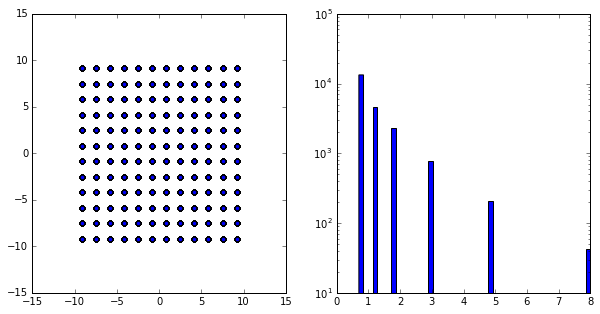

In [33]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(best_abs_models[:,0], best_abs_models[:,1])
plt.subplot(1,2,2)
_=plt.hist(best_abs_models[:,2], bins=50, )
plt.yscale('log')

## If output_val_scores was set to True, display the validation score for all candidate of one voxels and the time series of the best candidates for all voxels.

[-5.83333349 -9.16666698  1.13945305]
score range = (0.005600, 0.005797)


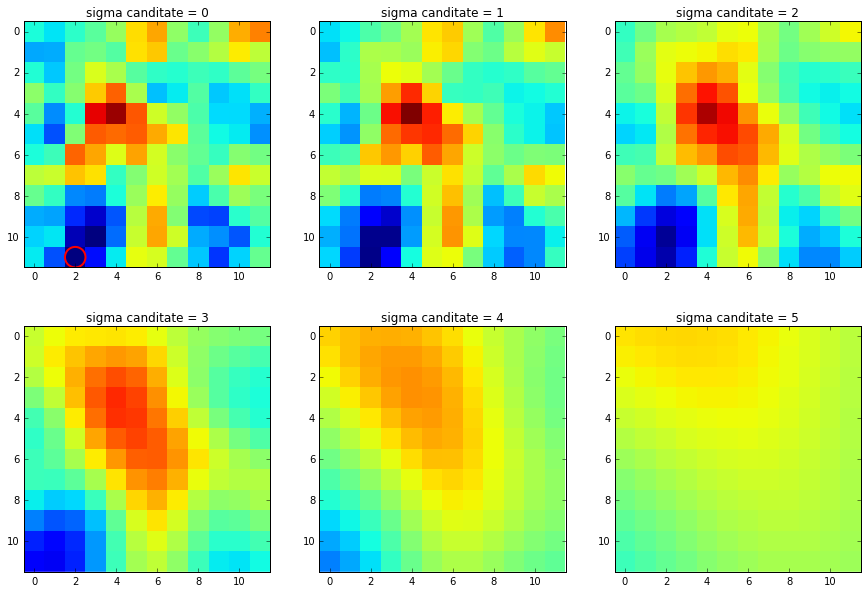

In [34]:
vidx = 266
print best_abs_models[vidx,:]
fig1 = display_candidate_loss(val_scores[-1,vidx,:], nx, ny, ns)

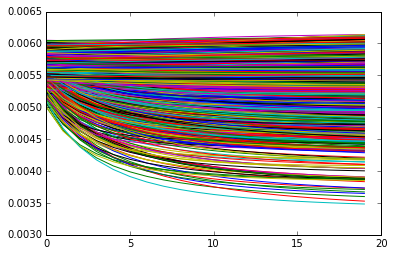

In [35]:
for v in range(val_scores.shape[1]):
    plt.plot(val_scores[:,v,best_rel_models[v]])

## Validate the best models and display the distribution of prediction accuracy.

In [36]:
val_pred, val_cc = fwrf.validate_models(val_rfw_data, valVoxelData, best_rel_models, best_params, use_data_as_rfw_data=True)

14 voxel batches of size 1440 with residual 1096


15it [03:17, 13.19s/it]


max cc = 0.817798
sum(cc>0.2) = 1819


(-0.4, 0.9)

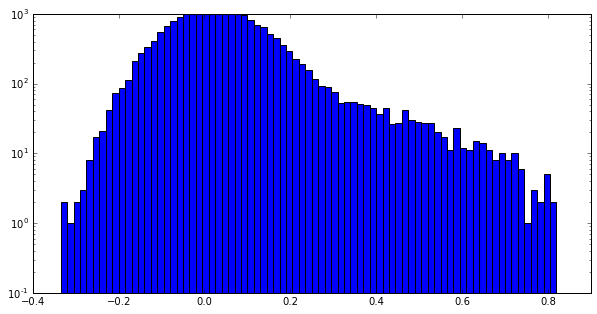

In [37]:
print "max cc = %f" % np.max(val_cc)
print "sum(cc>0.2) = %d" % np.sum(map(lambda x: x > 0.2, val_cc))
plt.figure(figsize=(10,5))
_=plt.hist(val_cc[:], bins=100, range=(-.5, 1.))
plt.yscale('log')
plt.ylim([10**-1, 10**3])
plt.xlim([-.4, 0.9])

[[ 1.         -0.06142908]
 [-0.06142908  1.        ]]


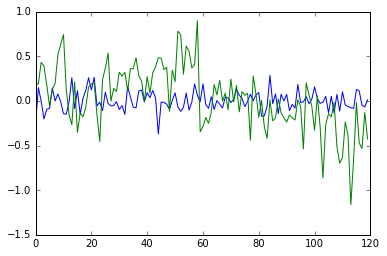

In [38]:
plt.plot(val_pred[:,vidx])
plt.plot(valVoxelData[:,vidx])

print np.corrcoef(val_pred[:,vidx], valVoxelData[:,vidx])

## Save the results

In [39]:
ex_file_name = "fwrf_%s_%s_data.pkl" % (subject, timestamp)
ex_file = open(output_dir + ex_file_name, 'wb')
ex_values = {'dataset': 'vim-1',
             'subject': subject,
             'model_name': 'deepnet',
             'grid': [sharedModel_specs[1][0](*sharedModel_specs[0][0]), 
                      sharedModel_specs[1][1](*sharedModel_specs[0][1]),
                      sharedModel_specs[1][2](*sharedModel_specs[0][2])],
             'fmaps_res_count': fmaps_res_count,
             'fmaps_count': fmaps_count,
             'fmaps_sizes': fmaps_sizes,      
             'scores': best_scores,
             'models': best_abs_models,
             'params': best_params,
             'val_pred': val_pred,
             'val_cc': val_cc}
pickle.dump(ex_values, ex_file)
ex_file.close()
print ex_file_name

fwrf_S2_Mar-22-2017_0239_data.pkl


# Split accuracy by layer and roi

In [40]:
#find the start and end point of the feature map partitions
fmaps_count = len(fmaps_sizes)
partitions = [0,]
for r in fmaps_sizes:
    partitions += [partitions[-1]+r[1],]
print partitions

[0, 96, 352, 736, 1120, 1376, 2400, 3424, 4424]


In [41]:
partition_val_pred = np.ndarray(shape=(fmaps_count,)+val_pred.shape, dtype=fpX)
partition_val_cc   = np.ndarray(shape=(fmaps_count,)+val_cc.shape, dtype=fpX)

for l in range(fmaps_count):
    partition_params = [np.zeros(p.shape, dtype=fpX) for p in best_params]  
    partition_params[0][:, partitions[l]:partitions[l+1]] = best_params[0][:, partitions[l]:partitions[l+1]]
    partition_params[1][:] = best_params[1][:]

    partition_val_pred[l,...], partition_val_cc[l,...] = fwrf.validate_models(val_rfw_data, valVoxelData, best_rel_models, partition_params, use_data_as_rfw_data=True)

14 voxel batches of size 1440 with residual 1096


15it [03:17, 13.15s/it]

14 voxel batches of size 1440 with residual 1096



15it [03:17, 13.17s/it]

14 voxel batches of size 1440 with residual 1096



15it [03:17, 13.14s/it]

14 voxel batches of size 1440 with residual 1096



15it [03:16, 13.10s/it]

14 voxel batches of size 1440 with residual 1096



15it [03:16, 13.11s/it]

14 voxel batches of size 1440 with residual 1096



15it [03:16, 13.11s/it]

14 voxel batches of size 1440 with residual 1096



15it [03:16, 13.08s/it]

14 voxel batches of size 1440 with residual 1096



15it [03:16, 13.07s/it]


In [42]:
# calculate covariances
partition_r = np.ndarray(shape=(fmaps_count, nv))
for v in range(nv):
    full_c = np.cov(val_pred[:,v], valVoxelData[:,v])
    for l in range(fmaps_count):
        part_c = np.cov(partition_val_pred[l,:,v], valVoxelData[:,v])
        partition_r[l,v] = part_c[0,1]/np.sqrt(full_c[0,0]*full_c[1,1])

In [43]:
part_file = open(output_dir + "fwrf_%s_%s_part.pkl" % (subject, timestamp), 'wb')
part_values = {'dataset': 'vim-1',
             'subject': subject,
             'model_name': 'deepnet',
             'val_pred': partition_val_pred,
             'val_cc': partition_val_cc,
             'val_ri': partition_r}
pickle.dump(part_values, part_file)
part_file.close()

In [44]:
nROI = int(np.max(voxelROI))+1
nL   = fmaps_count

partition_R_avg = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
partition_R_std = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
for roi in range(nROI):
    roi_mask = np.logical_and(voxelROI.flatten()==roi, val_cc>0.2)    
    for l in range(fmaps_count):
        partition_R_avg[l,roi] = np.mean(partition_r[l, roi_mask] /  val_cc[roi_mask])
        partition_R_std[l,roi] = np.std(partition_r[l, roi_mask])
#plt.imshow(partition_R_avg, interpolation='None')

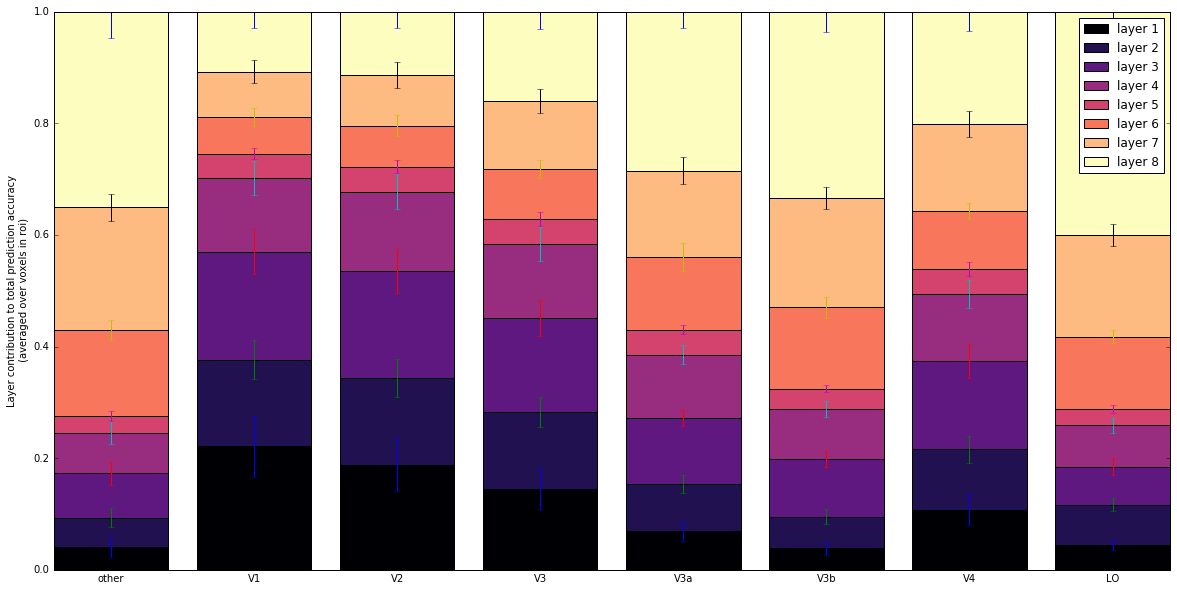

In [45]:
from matplotlib.pyplot import cm 
color=iter(cm.magma(np.linspace(0,1,nL)))

plt.figure(figsize=(20,10))
c=next(color)
plist = []
_ = plt.bar(np.arange(len(roi_names)), partition_R_avg[0,:], yerr=partition_R_std[0,:], color=c, align='center')
plist += [_,]
for l in range(1,nL):
    c=next(color)
    _= plt.bar(np.arange(len(roi_names)), partition_R_avg[l,:], bottom=np.sum(partition_R_avg[:l,:],axis=0), yerr=partition_R_std[l,:], color=c,\
        align='center', tick_label=roi_names)
    plist += [_,]
plt.legend(plist, ['layer %d' % l for l in range(1,len(plist)+1)])
plt.ylim([0,1])
plt.ylabel('Layer contribution to total prediction accuracy\n (averaged over voxels in roi)')